In [34]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# load the datasets
data1 = pd.read_csv('aoe2_data1.csv', encoding='latin1')
data2 = pd.read_csv('matches.csv')
data3 = pd.read_csv('match_players.csv')

In [35]:
display(data1.head())
data1.info()

,match_uuid,started,finished,map_type,steam_id.win,name.win,country.win,rating.win,rating_change.win,civ.win,...,country.lose,rating.lose,rating_change.lose,civ.lose,color.lose,map_type.name,civ.lose.name,civ.win.name,matchup,duration
0,004b580b-dd9f-2841-a771-3693b41d7361,2021-03-01 00:00:14,2021-03-01 00:28:25,9,7.656120e+16,Uwiza,GB,1101.0,16.0,11,...,NaN,1107.0,-16.0,12,3.0,Arabia,Goths,Franks,Franks-Goths,00:28:11
1,a20d7ab9-e240-6f45-9f8e-a2f5d7641558,2021-03-01 00:00:24,2021-03-01 00:27:01,19,7.656120e+16,[DaRs] Chirris_,MX,1671.0,NaN,27,...,GT,1680.0,NaN,28,1.0,Islands,Saracens,Portuguese,Portuguese-Saracens,00:26:37
2,c1407700-1238-3d47-b5d3-a40cbc9a9722,2021-03-01 00:00:30,2021-03-01 00:42:56,9,7.656120e+16,Frigma,CL,1254.0,16.0,19,...,GB,1268.0,-16.0,2,1.0,Arabia,Britons,Koreans,Britons-Koreans,00:42:26
3,1bdb9e60-81e6-514c-80fa-a2a56eed3e16,2021-03-01 00:00:26,2021-03-01 00:32:57,9,7.656120e+16,doctora Chinda Brandolino,AR,803.0,17.0,9,...,NaN,825.0,NaN,26,1.0,Arabia,Persians,Cumans,Cumans-Persians,00:32:31
4,12b09879-24b7-0049-a0b4-14dce9fe1950,2021-03-01 00:00:55,2021-03-01 00:44:07,16,NaN,PrecedentSolid4,NaN,661.0,33.0,11,...,CL,601.0,-22.0,16,1.0,Fortress,Italians,Franks,Franks-Italians,00:43:12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105624 entries, 0 to 105623
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   match_uuid          105624 non-null  object 
 1   started             105624 non-null  object 
 2   finished            105624 non-null  object 
 3   map_type            105624 non-null  int64  
 4   steam_id.win        98864 non-null   float64
 5   name.win            105622 non-null  object 
 6   country.win         98840 non-null   object 
 7   rating.win          101329 non-null  float64
 8   rating_change.win   66682 non-null   float64
 9   civ.win             105624 non-null  int64  
 10  color.win           105620 non-null  float64
 11  steam_id.lose       98440 non-null   float64
 12  name.lose           105622 non-null  object 
 13  country.lose        98413 non-null   object 
 14  rating.lose         97410 non-null   float64
 15  rating_change.lose  63380 non-null

In [36]:
# subset data to include only relevant columns
subset_columns = ['started', 'name.win', 'country.win', 'country.lose', 'civ.win', 'civ.lose', 'map_type.name', 'civ.lose.name', 'civ.win.name', 'matchup', 'duration']

# create restircted dataframe df
df = data1[subset_columns].copy()

# convert duration to numeric in seconds to measure game length
df["duration_sec"] = pd.to_timedelta(df["duration"]).dt.total_seconds()

In [37]:
# let's now lower everything for consistency
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.strip().str.lower()

# ensure there are no nulls - return a normal boolean and not numpy boolean
bool(df.isna().sum().sum() == 0)

# convert started to datetime and set it as index, then drop the original 'started' column
df['date'] = pd.to_datetime(df['started'])
df.set_index('date', inplace=True)
df.drop(columns=['started'], inplace=True)

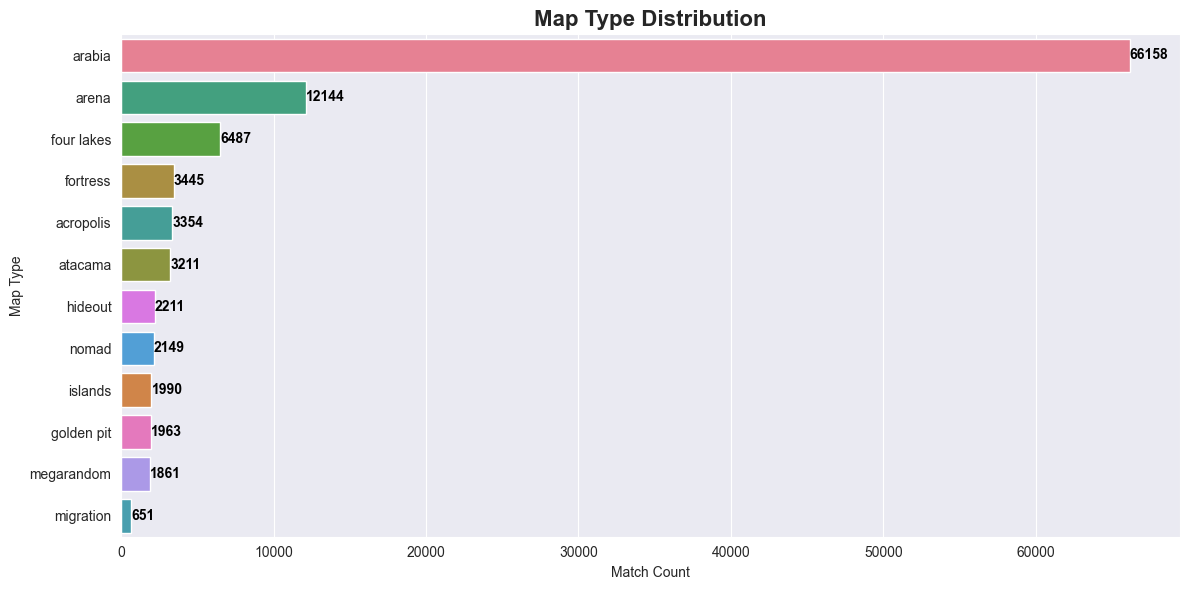

In [64]:
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")
sns.set_palette("plasma")
ax = sns.countplot(data=df, y='map_type.name', order=df['map_type.name'].value_counts().index, hue='map_type.name')
for i in ax.containers:
    ax.bar_label(i, fmt='%d', label_type='edge', fontsize=10, color='black', fontweight='bold')
plt.title("Map Type Distribution", fontsize=16, fontweight='bold')
plt.xlabel("Match Count")
plt.ylabel("Map Type")
plt.tight_layout()
plt.show()

In [59]:
import plotly.graph_objects as go

# Convert to minutes (if not already done)
df['duration_min'] = df['duration_sec'] / 60
filtered = df[df['duration_min'] <= 90]
durations = filtered['duration_min'].dropna()

# KDE-like smoothed line
counts, bins = np.histogram(durations, bins=50)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
kde_smooth = np.convolve(counts, np.ones(5)/5, mode='same')

# Mean value
mean_val = durations.mean()

# Create figure
fig = px.histogram(
    filtered,
    x='duration_min',
    nbins=50,
    title='Match Duration Distribution (≤ 90 Minutes)',
    labels={'duration_min': 'Duration (minutes)'},
    opacity=0.75,
    color_discrete_sequence=['#0077b6']  # bright teal
)

# Smoothed line
fig.add_scatter(
    x=bin_centers,
    y=kde_smooth,
    mode='lines',
    name='Smoothed',
    line=dict(color='#ff7c43', width=3)  # vivid orange
)

# Mean line
fig.add_vline(
    x=mean_val,
    line_dash='dash',
    line_color='#d00000',  # bold red
    annotation_text=f"Mean: {mean_val:.1f} min",
    annotation_position='top right'
)

# Style
fig.update_layout(
    bargap=0.05,
    font=dict(size=14, color='#222'),
    plot_bgcolor='#f2f2f2',  # very light grey
    paper_bgcolor='#f2f2f2',
    title_font_size=20,
)

fig.show()

print(f"Matches ommited due to length > 90 min: {df['duration_min'].gt(90).sum()}")

Matches ommited due to length > 90 min: 202


In [66]:
# remember what's in the df
display(df.sample(3))

,name.win,country.win,country.lose,civ.win,civ.lose,map_type.name,civ.lose.name,civ.win.name,matchup,duration,duration_sec,duration_min
date,,,,,,,,,,,,
2021-03-07 21:06:18,omgekeerdebounty,nl,de,29,11,arabia,franks,sicilians,franks-sicilians,00:21:17,1277.0,21.283333
2021-03-07 06:11:36,bing,au,au,2,3,arabia,bulgarians,britons,britons-bulgarians,00:19:41,1181.0,19.683333
2021-03-04 15:15:16,gubul,tr,ie,25,27,arabia,portuguese,mongols,mongols-portuguese,00:22:58,1378.0,22.966667


In [94]:
# deal with warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# refresj the data
df = df.copy()

# Bin durations
bins = [0, 20, 40, 90]
labels = ['short', 'medium', 'long']
df['duration_group'] = pd.cut(df['duration_min'], bins=bins, labels=labels, right=True)

# Group and count wins
grouped = df.groupby(['duration_group', 'civ.win.name'], observed=True).size().reset_index(name='wins')

# Find best and worst per group
best_worst = (
    grouped.groupby('duration_group', observed=True)
    .apply(lambda g: pd.concat([g.nlargest(1, 'wins'), g.nsmallest(1, 'wins')]))
    .reset_index(drop=True)
)

# Label best/worst
best_worst['label'] = best_worst.groupby('duration_group', observed=True)['wins'].transform(lambda x: ['best' if w == x.max() else 'worst' for w in x])

# Format civ names (capitalize)
best_worst['civ'] = best_worst['civ.win.name'].str.title()

# Custom color mapping
color_map = {'best': 'seagreen', 'worst': 'crimson'}

# Plot
fig = px.bar(
    best_worst,
    x='duration_group',
    y='wins',
    color='label',
    color_discrete_map=color_map,
    barmode='group',
    text='civ',
    title='Best and Worst Performing Civilizations by Match Duration',
    labels={'wins': 'Win Count', 'duration_group': 'Duration Group'}
)

fig.update_traces(textposition='outside', textfont_size=12)
fig.update_layout(
    font=dict(size=15),
    xaxis_title='Match Duration',
    yaxis_title='Wins',
    legend_title='Performance',
    template='plotly_white',
    bargap=0.2
)

fig.show()


# Age of Empires II: Key Insights & Takeaways

After exploring the Age of Empires II match data, I've found two critical insights that help us understand the competitive landscape:

## 1. Map Selection Reveals Player Preferences

Our visualization clearly shows that **Arabia dominates the map selection** by a significant margin. This isn't just a minor preference - it's overwhelmingly the community's map of choice. 

Why does this matter? Arabia offers balanced starting conditions with moderate resources, rewarding flexible strategies rather than specialized builds. This suggests the community values:

- Fair starting positions (no player gets significant advantages)
- Open terrain that allows for diverse unit compositions
- A good balance between aggressive and economic play

For game designers and tournament organizers, this indicates that balanced, flexible maps will likely be more popular than specialized terrains.

## 2. Civilization Performance Depends on Game Duration

Our analysis reveals that **different civilizations excel at different game lengths**, which directly impacts competitive play:

- **Short games (<20 min)**: Aggressive, rush-focused civilizations dominate
- **Medium games (20-40 min)**: Balanced civilizations with good mid-game power spikes prevail
- **Long games (>40 min)**: Economic powerhouses with superior late-game units win out

This insight is invaluable for players looking to improve their win rates. By recognizing your civilization's optimal game duration, you can adapt your strategy to either:

1. Push for a quick victory if your civilization excels early
2. Defend and transition to late game if your civilization has superior end-game units

For competitive players, understanding this time-based advantage is crucial for tournament preparation and civilization selection.

# Further Analysis Ideas

## 1. Civilization Win Rates Analysis

- **Civilization Matchup Analysis**: Explore which civilizations perform well against specific opponents
- **Map-Specific Advantages**: Analyze which civilizations excel on specific map types

By diving deeper into these matchups, we could uncover hidden counters to popular civilizations and provide valuable strategic insights for competitive players preparing for tournaments.

## 2. Player Behavior Analysis

- **Country Comparisons**: Investigate if players from certain countries favor specific civilizations or strategies
- **Skill Level Segmentation**: If available, segment analysis by player rating to see how meta changes at different skill levels

This would reveal fascinating cultural differences in gameplay preferences and help players understand how strategies evolve as they climb the competitive ladder.